In [2]:
!pip install arch

# GARCH
* [GARCH Website](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)

In [1]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df
from MSM_util import *
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import sys, scipy, numpy

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


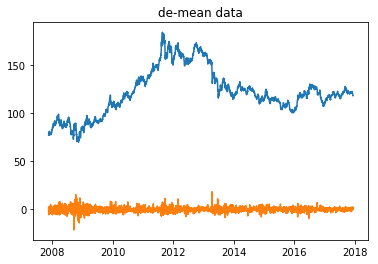

In [2]:
# Hyper parameters

# How much period taken into calculation and prediction
m = 20
# number of days prediction
RV = 22
# kbar
kbar = 8

xls_data = pd.read_excel('data_GVZ_GLD.xlsx')
date_GLD = xls_data.iloc[:,3]
GLD = xls_data.loc[:,'GLD']

GLD2 = GLD.shift(1)
GLD2[0] = GLD[0]
GLD_r = np.log(GLD/GLD2)

GLD_d = GLD_r - np.mean(GLD_r)
plt.plot(date_GLD,GLD)
plt.title('de-mean data')
plt.plot(date_GLD,200*GLD_r)

data = GLD_d[::-1]


startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 5]
op_methods = 'slsqp'



plt.show()

In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Model1 TEST

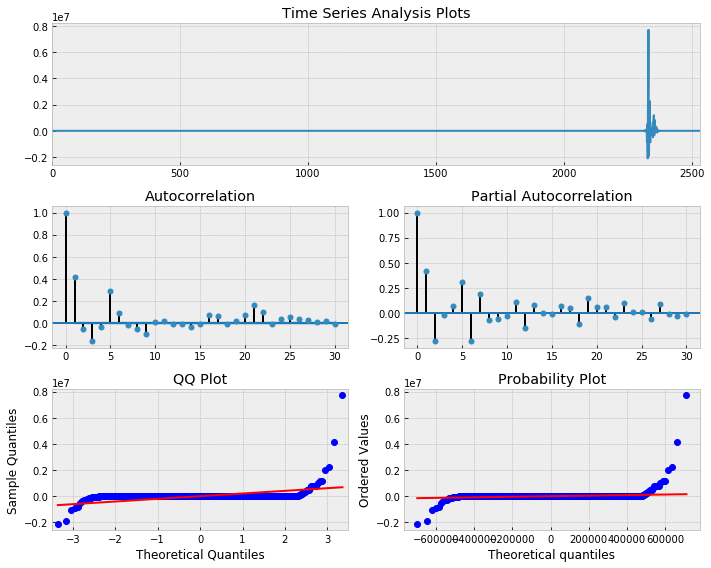

In [4]:

a0 = 0.1
a1 = 0.5
b1 = 0.3

w = GLD_d/np.std(GLD_d)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, len(GLD_d)):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

In [5]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())


Iteration:      5,   Func. Count:     38,   Neg. LLF: 28699.466988245593
Iteration:     10,   Func. Count:     68,   Neg. LLF: 28699.28530979977
Iteration:     15,   Func. Count:     98,   Neg. LLF: 28691.783263773377
Iteration:     20,   Func. Count:    128,   Neg. LLF: 28611.505030022636
Iteration:     25,   Func. Count:    162,   Neg. LLF: 28553.901587193508
Iteration:     30,   Func. Count:    193,   Neg. LLF: 28552.9274090419
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28552.927409903044
            Iterations: 30
            Function evaluations: 193
            Gradient evaluations: 30
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -28552.9
Distribution:                  Normal

## Model2 + Forecast
[forecast GARCH](http://arch.readthedocs.io/en/latest/univariate/forecasting.html)

In [6]:
returns = GLD_r*100
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [7]:
# split_date = dt.datetime(2010,1,1)
res = am.fit()#last_obs = split_date)
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3825.014770625835
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3824.592333966819
Iteration:      3,   Func. Count:     24,   Neg. LLF: 3824.2189992718763
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3823.440878972009
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3819.3183763082434
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3818.695194042147
Iteration:      7,   Func. Count:     54,   Neg. LLF: 3817.596365949996
Iteration:      8,   Func. Count:     61,   Neg. LLF: 3817.4264754409646
Iteration:      9,   Func. Count:     67,   Neg. LLF: 3817.336455265128
Iteration:     10,   Func. Count:     73,   Neg. LLF: 3817.1868171101105
Iteration:     11,   Func. Count:     79,   Neg. LLF: 3817.180821399338
Iteration:     12,   Func. Count:     85,   Neg. LLF: 3817.1806886428117
Iteration:     13,   Func. Count:     91,   Neg. LLF: 3817.18068721023
Optimization terminated successfully.    (Exit mode 0)
     

### Forecast

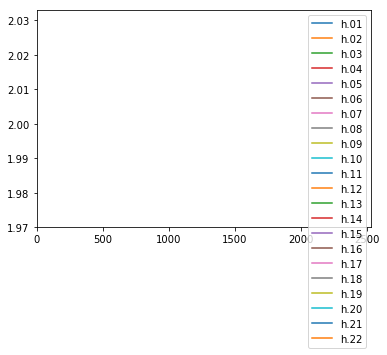

In [12]:
forecasts = res.forecast(horizon=22) #, start=split_date)
forecasts.variance.plot()

# forecasts.variance[split_date:].plot()

In [21]:
forecasts.residual_variance[-1:]

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.13,h.14,h.15,h.16,h.17,h.18,h.19,h.20,h.21,h.22
2532,2.030156,2.027219,2.024304,2.021412,2.018541,2.015692,2.012864,2.010058,2.007273,2.004509,...,1.996342,1.99366,1.990999,1.988358,1.985737,1.983136,1.980554,1.977992,1.97545,1.972926


In [19]:
forecasts.variance[-1:]

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.13,h.14,h.15,h.16,h.17,h.18,h.19,h.20,h.21,h.22
2532,2.030156,2.027219,2.024304,2.021412,2.018541,2.015692,2.012864,2.010058,2.007273,2.004509,...,1.996342,1.99366,1.990999,1.988358,1.985737,1.983136,1.980554,1.977992,1.97545,1.972926


# MSGARCH


* [web site](https://github.com/ChadFulton/statsmodels/blob/master/examples/notebooks/markov_autoregression.ipynb)

## TEST

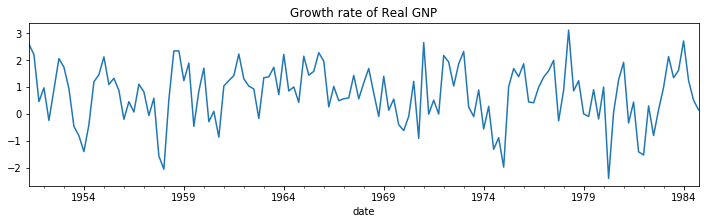

In [23]:
# Get the RGNP data to replicate Hamilton
dta = pd.read_stata('http://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq='QS')
dta_hamilton = dta.rgnp

# Plot the data
dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(12,3))



In [24]:
# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Mon, 12 Feb 2018   AIC                            380.527
Time:                          15:47:56   BIC                            406.404
Sample:                      04-01-1952   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical differentiation.
"""

In [8]:
!pip install certifi

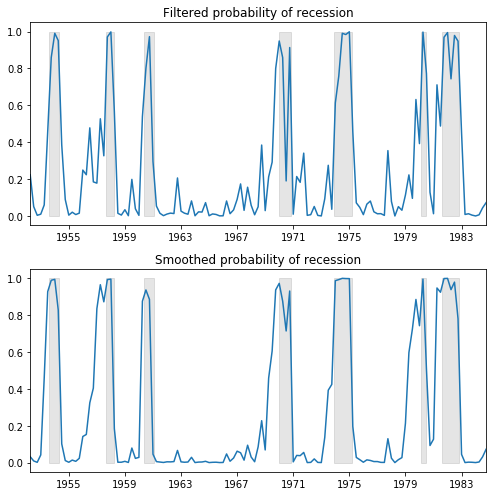

In [25]:
# NBER recessions
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

fig, axes = plt.subplots(2, figsize=(7,7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k', alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title='Filtered probability of recession')

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k', alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title='Smoothed probability of recession')

fig.tight_layout()

In [26]:
GLD_d

0       0.000166
1       0.000251
2       0.013413
3       0.002246
4       0.007288
5       0.003544
6      -0.003872
7       0.007899
8       0.006456
9       0.000329
10     -0.003994
11      0.002697
12     -0.009009
13     -0.001481
14      0.012863
15     -0.011788
16      0.000249
17      0.001401
18     -0.001892
19     -0.001319
20      0.008388
21     -0.003936
22     -0.003293
23      0.003790
24     -0.008337
25      0.004881
26     -0.000494
27     -0.003473
28      0.003971
29     -0.001734
          ...   
2503   -0.028523
2504    0.006694
2505   -0.017335
2506   -0.000324
2507   -0.016907
2508   -0.000333
2509   -0.017848
2510    0.007386
2511    0.000292
2512   -0.014067
2513    0.005146
2514   -0.000088
2515    0.025201
2516   -0.020546
2517    0.014772
2518   -0.017489
2519    0.009915
2520   -0.009201
2521    0.009911
2522   -0.014040
2523   -0.012173
2524    0.012506
2525    0.016511
2526    0.006805
2527    0.015036
2528   -0.000449
2529   -0.023370
2530    0.0015

In [27]:
date_GLD.rename("date")
GLD_ddate = GLD_d.rename(date_GLD)
GLD_ddate

2017-12-08    0.000166
2017-12-07    0.000251
2017-12-06    0.013413
2017-12-05    0.002246
2017-12-04    0.007288
2017-12-01    0.003544
2017-11-30   -0.003872
2017-11-29    0.007899
2017-11-28    0.006456
2017-11-27    0.000329
2017-11-24   -0.003994
2017-11-22    0.002697
2017-11-21   -0.009009
2017-11-20   -0.001481
2017-11-17    0.012863
2017-11-16   -0.011788
2017-11-15    0.000249
2017-11-14    0.001401
2017-11-13   -0.001892
2017-11-10   -0.001319
2017-11-09    0.008388
2017-11-08   -0.003936
2017-11-07   -0.003293
2017-11-06    0.003790
2017-11-03   -0.008337
2017-11-02    0.004881
2017-11-01   -0.000494
2017-10-31   -0.003473
2017-10-30    0.003971
2017-10-27   -0.001734
                ...   
2007-12-31   -0.028523
2007-12-28    0.006694
2007-12-27   -0.017335
2007-12-26   -0.000324
2007-12-24   -0.016907
2007-12-21   -0.000333
2007-12-20   -0.017848
2007-12-19    0.007386
2007-12-18    0.000292
2007-12-17   -0.014067
2007-12-14    0.005146
2007-12-13   -0.000088
2007-12-12 

In [13]:
# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(GLD_ddate, k_regimes=2, order=1, switching_ar=True)
res_hamilton = mod_hamilton.fit()

res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      GLD   No. Observations:                 2532
Model:             MarkovAutoregression   Log Likelihood                7608.896
Date:                  Sun, 11 Feb 2018   AIC                         -15203.793
Time:                          14:28:02   BIC                         -15162.935
Sample:                      12-07-2017   HQIC                        -15188.969
                           - 11-16-2007                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.471      0.637      -0.003       0.005
ar.L1          0.7162      0.096      7.499      0.000       0.529       0.903
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.718      0.473      -0.001       0.000
ar.L1         -0.1217      0.027     -4.520      0.000      -0.174      -0.069
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   4.06e-06     33.279      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.1512      0.079      1.914      0.056      -0.004       0.306
p[1->0]        0.0956      0.035      2.697      0.007       0.026       0.165
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical differentiation.
"""

In [32]:
# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(GLD_ddate, k_regimes=2, order=1, switching_ar=True, switching_variance= True)
res_hamilton = mod_hamilton.fit()

res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      GLD   No. Observations:                 2532
Model:             MarkovAutoregression   Log Likelihood                7845.763
Date:                  Mon, 12 Feb 2018   AIC                         -15675.526
Time:                          15:49:05   BIC                         -15628.831
Sample:                      12-07-2017   HQIC                        -15658.584
                           - 11-16-2007                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.863      0.388      -0.001       0.000
sigma2      7.039e-05   3.75e-06     18.759      0.000     6.3e-05    7.77e-05
ar.L1         -0.0077      0.026     -0.299      0.765      -0.058       0.043
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.624      0.533      -0.001       0.002
sigma2         0.0003   2.17e-05     14.866      0.000       0.000       0.000
ar.L1         -0.0102      0.037     -0.277      0.782      -0.083       0.062
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9896      0.004    273.472      0.000       0.982       0.997
p[1->0]        0.0234      0.008      2.963      0.003       0.008       0.039
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical differentiation.
"""

In [33]:
sm.tsa.MarkovAutoregression(switching_trend=)

SyntaxError: invalid syntax (<ipython-input-33-35bc17959f26>, line 1)